## Distribution functions

In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np


In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [3]:
pgrid_dir = "data/article_data/jgr_5"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

helps, hvars = lg.load_helpfiles(cases)
cvars = lg.load_cvars(cases)

Configs: 100%|██████████| 1029/1029 [00:02<00:00, 395.29it/s]


In [4]:
# %matplotlib widget
%matplotlib inline

In [5]:
# https://stackoverflow.com/a/65972406
def _ecdf(a):
    a = np.sort(a)
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

In [6]:
def ecdf_flat(dep_key, dep_lbl, logy=False):

    x, y = _ecdf(lg.access_hvars(hvars,dep_key,-1))

    fig,ax = plt.subplots(1,1)
    ax.plot(x, y, color='black', drawstyle='steps-post')
    ax.set_xlabel(dep_lbl)
    ax.set_ylabel("Count")
    plt.show()

### Plot eCDFs for different values of an independent variable

In [7]:
def ecdf_indep(dep_key,dep_lbl, indep_key,indep_lbl, logx=False, logy=False, logz=False):

    fig,ax = plt.subplots(1,1, figsize=(5,4))
    lw = 4
    al = 0.75

    # Get all values of indep variable used in grid
    indep_vals = cvars[indep_key]
    indep_vals = sorted(list(set(indep_vals)))

    # Setup cmap,norm
    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
    cmap = sci_colormaps['roma']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # Dependent variable values
    dep_vals = lg.access_hvars(hvars,dep_key,-1)
   
    for indep_val in indep_vals: # for each value of the independent variable, make ecdf plot
        dat = []
        for i in range(ncases):
            if np.isclose(cvars[indep_key][i], indep_val):
                dat.append(dep_vals[i])
        x, y = _ecdf(dat) 
        ax.plot(x, y, c=sm.to_rgba(indep_val),
                alpha=al, lw=lw, drawstyle='steps-post', label=str(indep_val))

    # finalise plot
    # ax.set_ylabel("Cumulative probability")
    ax.set_xlabel(dep_lbl)
    ax.legend(title=indep_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.show()

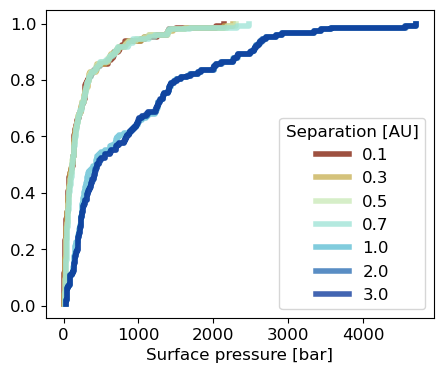

In [8]:
# x = "Time"; x_lbl = "Termination time [yr]"; logx=True
x,x_lbl = "P_surf", "Surface pressure [bar]"; logx=False

# z = "CH_ratio"; z_lbl = "C/H ratio"; logz=True
# z = "fO2_shift_IW"; z_lbl = "Oxygen fugacity"; logz=False
z =  "mean_distance"; z_lbl = "Separation [AU]"; logz=True

ecdf_indep(
    x,x_lbl,
    z,z_lbl,
    logz=logz,
    logx=logx,
)

### Plot eCDFS for different independent and dependent variables combinations

In [57]:
def ecdf_many(deps, indeps, 
              label_y_axes=True, tick_y_axes=True, figsize=(10,7), figscale=1.0,
              lw=3, al=0.96, scatter_ends=False, label_panels=True):

    ndep = len(deps)
    nind = len(indeps)

    alphabet = [chr(i) for i in range(ord('a'),ord('z')+1)]

    fig,axs = plt.subplots(nind, ndep, figsize=(figsize[0]*figscale, figsize[1]*figscale))

    # For each independent, dependent variable combination
    counter = -1
    for idx_ind in range(nind):
        for idx_dep in range(ndep):
            counter += 1

            if (nind == 1) and (ndep == 1):
                ax = axs
            elif (nind == 1):
                ax = axs[idx_dep]
            elif (ndep == 1):
                ax = axs[idx_ind]
            else:
                ax = axs[idx_ind, idx_dep]
            indep_key = indeps[idx_ind]["key"]
            dep_key = deps[idx_dep]["key"]

            # Get all values of indep variable used in grid
            indep_vals = cvars[indep_key]
            indep_vals = sorted(list(set(indep_vals)))

            # Setup cmap,norm for this indep variable
            if not indeps[idx_ind]["log"]:
                norm = mpl.colors.Normalize(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
            else:
                norm = mpl.colors.LogNorm(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
            cmap_name = indeps[idx_ind]["cmap"].strip()
            if cmap_name in sci_colormaps.keys():
                cmap = sci_colormaps[cmap_name]
            else:
                cmap = cmap_name
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            colorbar = bool(indeps[idx_ind]["cbar"])

            # Dependent variable values
            #    special cases
            if dep_key == "Time_solid":
                dep_key = "Time"
                tme_vals = lg.access_hvars(hvars,"Time",-1)
                phi_vals = lg.access_hvars(hvars,"Phi_global",-1)
                dep_vals = []
                for i in range(len(phi_vals)):
                    if phi_vals[i] < 0.006:
                        dep_vals.append(tme_vals[i])
                    else:
                        dep_vals.append(np.inf)
                dep_vals = np.array(dep_vals)

            #    else 
            else:
                dep_vals = lg.access_hvars(hvars,dep_key,-1)

            # Plot the eCFS for this dep variable
            for indep_val in indep_vals: # for each value of the indep var
                dat = []
                for i in range(ncases):
                    if np.isclose(cvars[indep_key][i], indep_val):
                        if not np.isnan(dep_vals[i]):
                            dat.append(dep_vals[i] * deps[idx_dep]["scale"])

                if len(dat) < 2:
                    continue
                x, y = _ecdf(dat) 
                y *= 10.0
                
                c = sm.to_rgba(indep_val)
                # ax.plot(x, y, c='black', alpha=0.2, lw=lw, drawstyle='steps-post', zorder=1)
                ax.plot(x, y, c=c, alpha=al, lw=lw, drawstyle='steps-post', label="%g"%indep_val, zorder=3)
                if scatter_ends:
                    ax.scatter([x[0],x[-1]],[y[0],y[-1]], color=c)

            # X-axis labels on bottom-most subplots
            if idx_ind == nind-1:
                ax.set_xlabel(deps[idx_dep]["label"])
                ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=5) )
            else:
                for _x in ax.xaxis.get_major_ticks():  # (this is ugly but it is the only method which removes log-ticks)
                    _x.label1.set_visible(False)

            # Legends or cbars on right-most subplots
            if idx_dep == ndep-1:
                _tit = indeps[idx_ind]["label"]
                if colorbar:
                    cax = make_axes_locatable(ax).append_axes('right', size='10%', pad=0.1)
                    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(_tit, verticalalignment='bottom', labelpad=15) 
                else:
                    if indeps[idx_ind]["log"]:
                        _tit += r"$^{\dag}$"
                    ax.legend(title=_tit,loc='center left', bbox_to_anchor=(1, 0.5))

            # Remove ticks and label y-axis
            if not tick_y_axes:
                ax.set_yticks([])
            else:
                ax.set_yticks([0, 5, 10])
                ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
                if idx_dep > 0:
                    ax.set_yticklabels([])
            if label_y_axes:
                fig.supylabel("Empirical cumulative distributions (deciles)", ha='left', x=0.005)
            
            # Set x-axis scale
            if deps[idx_dep]["log"]:
                ax.set_xscale("log")
                ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))

                ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1)) )
                ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
            else:
                ax.set_xscale("linear")
            
            # Set x-axis locator
            if deps[idx_dep]["mloc"] != None:
                ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(deps[idx_dep]["mloc"]))

            # Data grid 
            ax.grid(zorder=-2, which='major', axis='y', alpha=0.2)

            # Panel label
            if label_panels:
                axlbl = ax.text(0.95, 0.05, "("+alphabet[counter]+")", transform=ax.transAxes, ha='right', va='bottom')
                axlbl.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))
    
    fig.tight_layout(pad=0.3)
    fig.savefig("output/recent_ecdf_many.pdf", bbox_inches='tight')
    plt.show()

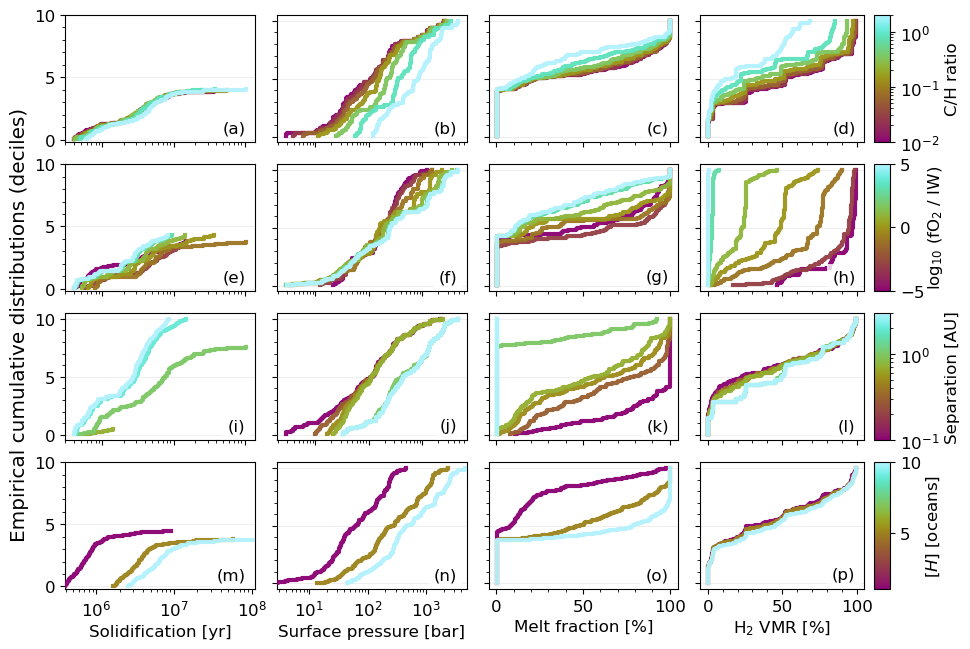

In [58]:
# Dependent variables
xs = [
    {
        "key":      "Time_solid",
        "label":    "Solidification [yr]",
        "scale":    1.0,
        "log":      True,
        "mloc":     None
    },
    {
        "key":      "P_surf",
        "label":    "Surface pressure [bar]",
        "scale":    1.0,
        "log":      True,
        "mloc":     None
    },
    {
        "key":      "Phi_global",
        "label":    "Melt fraction [%]",
        "scale":    100.0,
        "log":      False,
        "mloc":     10.0
    },
    {
        "key":      "H2_mr",
        "label":    "H$_2$ VMR [%]",
        "scale":    100.0,
        "log":      False,
        "mloc":     10.0
    }
]

# Independent variables
zs = [
    {
        "key":      "CH_ratio",
        "label":    "C/H ratio",
        "scale":    1.0,
        "log":      True,
        "cmap":     "hawaii",
        "cbar":     True,
    },
    {
        "key":      "fO2_shift_IW",
        "label":    "log$_{10}$ (fO$_{2}$ / IW)",
        "scale":    1.0,
        "log":      False,
        "cmap":     "hawaii",
        "cbar":     True,
    },
    {
        "key":      "mean_distance",
        "label":    "Separation [AU]",
        "scale":    1.0,
        "log":      True,
        "cmap":     "hawaii",
        "cbar":     True
    },
    {
        "key":      "hydrogen_earth_oceans",
        "label":    "$[H]$ [oceans]",
        "scale":    1.0,
        "log":      False,
        "cmap":     "hawaii",
        "cbar":     True
    }
]

plt.close("all")
ecdf_many(xs,zs, figsize=(6,4), figscale=1.6)


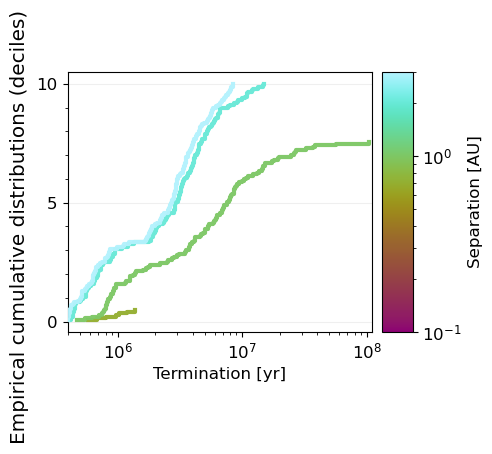

In [55]:
# Dependent variables
xs = [
    {
        "key":      "Time_solid",
        "label":    "Termination [yr]",
        "scale":    1.0,
        "log":      True,
        "mloc":     None
    }
]

# Independent variables
zs = [
    {
        "key":      "mean_distance",
        "label":    "Separation [AU]",
        "scale":    1.0,
        "log":      True,
        "cmap":     "hawaii",
        "cbar":     True
    }
]

plt.close("all")
ecdf_many(xs,zs, figsize=(3,2), figscale=1.6, label_panels=False)
